#### This models what occurs in the systems, from a starting point of the drug being injected subcutaneously and how it behaves from there — the AD part of ADME.

# Imports and useful functions

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
plt.rcParams['font.sans-serif'] = ['Arial']

## Define parameters

In [3]:
# "Finalized" or "ultimate" parameters
k_ABS = 1  # Absorption rate constant DONE
k_CP = 0.01  # Rate constant from central to peripheral compartment DONE
k_PC = 0.01  # Rate constant from peripheral to central compartment DONE
k_Celim = 0.001  # Elimination rate constant (30 day half-life) DONE
k_CT = 0.01  # Rate constant for tumor homing DONE
k_TC = 0.001  # Rate constant for leaving the tumor compartment DONE
k_CL = 0.001  # Rate constant for accumulation in the liver DONE
k_TMEelim = 0.00001  # TME effects reducing persistence in the tumor DONE

V_CENTRAL = 3.0  # Volume of central compartment [Liters], plasma in blood
V_TUMOR = 0.1  # Volume of tumor compartment [Liters], average size of a large tumor (100 cm^3)
dose = 450 # or 450 # Initial dose [10^6 cells]
AVOGADRO = 6.022e23  # Avogadro's number [molecules/mol]

dose_moles = dose / AVOGADRO

In [4]:
parameter_sweep = {
    'k_ABS': 1, # If IV injection, dose is immediately available in the central compartment.
    'k_CP': np.logspace(-6, -1, 6), # [1/hour] Wide range of values
    'k_PC': np.logspace(-6, -1, 6), # [1/hour]
    'k_Celim': 0.001, # [1/hour]
    'k_CT': np.logspace(-6, -1, 6), # [1/hour] Depending on efficacy of design
    'k_TC': np.logspace(-3, -1, 6), # [1/hour] Depends on tumor's ability to retain drug
    'k_CL': np.logspace(-6, -1, 6), # [1/hour] Cachectic patients might suffer from higher levels of trafficking into the liver
    'k_TMEelim': 0.00001, # [1/hour] TME effects reducing persistence in the tumor
    'dose': [20, 70, 140, 200, 300, 450], # [10^6 of cells, determined for a 70 kg individual]
}

## Define the model

In [5]:
# Define the multi-compartment model with biodistribution and TME effects
def pk_model(y, t, k_ABS, k_CP, k_PC, k_Celim, k_CT, k_TC, k_CL, k_TMEelim):
    dAdt = -k_ABS * y[0]  # Dosing compartment
    dCdt = (k_ABS * y[0] / V_CENTRAL) - (k_CP + k_CT + k_CL + k_Celim) * y[1] \
           + k_PC * y[2] + k_TC * y[3]  # Central compartment
    dPdt = k_CP * y[1] - k_PC * y[2]  # Peripheral compartment
    dTdt = k_CT * y[1] - (k_TC + k_TMEelim) * (y[3])  # Tumor compartment
    dLiverdt = k_CL * y[1]  # Liver compartment (accumulation only)
    return [dAdt, dCdt, dPdt, dTdt, dLiverdt]

## Simulation and solving the ODE

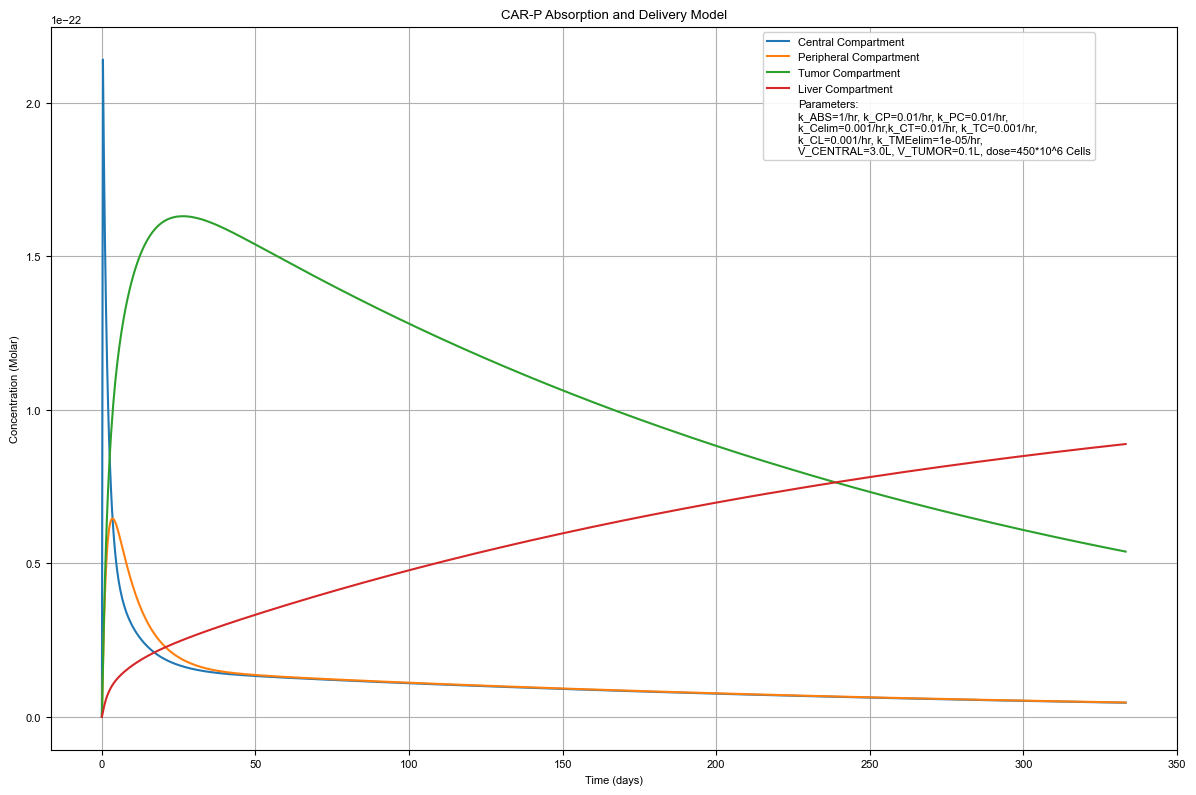

In [6]:
# Time points for simulation
t = np.linspace(0, 8000, 1000)  # Simulate over 48 hours with fine resolution
t_days = t / 24

# Initial conditions: [Dosing Compartment [mol], Central Compartment [mol], Peripheral Compartment [mol], Tumor Compartment [mol], Liver Compartment [mol]]
y0_updated = [dose_moles, 0, 0, 0, 0]

# Solver options for increased precision
solver_options = {'atol': 1e-25, 'rtol': 1e-9} # Adjust tolerances as needed

# Solve ODE for the updated model
solution_updated = odeint(pk_model, y0_updated, t,
                          args=(k_ABS, k_CP, k_PC, k_Celim, k_CT, k_TC,
                                k_CL, k_TMEelim), **solver_options)

# Plot results in DAYS
plt.figure(figsize=(12, 8))
plt.plot(t_days, solution_updated[:, 1], label='Central Compartment')
plt.plot(t_days, solution_updated[:, 2], label='Peripheral Compartment')
plt.plot(t_days, solution_updated[:, 3], label='Tumor Compartment')
plt.plot(t_days, solution_updated[:, 4], label='Liver Compartment')


# Add parameters to the legend
parameters_text = (
    f"k_ABS={k_ABS}/hr, k_CP={k_CP}/hr, k_PC={k_PC}/hr,\n" 
    f"k_Celim={k_Celim}/hr,k_CT={k_CT}/hr, k_TC={k_TC}/hr,\n"
    f"k_CL={k_CL}/hr, k_TMEelim={k_TMEelim}/hr,\n"
    f"V_CENTRAL={V_CENTRAL}L, V_TUMOR={V_TUMOR}L, dose={dose}*10^6 Cells"
)
plt.plot([], [], ' ', label=f"Parameters:\n{parameters_text}")

# Add labels and title
plt.xlabel('Time (days)')
plt.ylabel('Concentration (Molar)')
plt.title('CAR-P Absorption and Delivery Model')

# Add legend on top of the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.78, 1), frameon=True, framealpha=0.9, ncol=1)  # Adjust position and transparency
plt.grid(True)
plt.tight_layout()
plt.show()

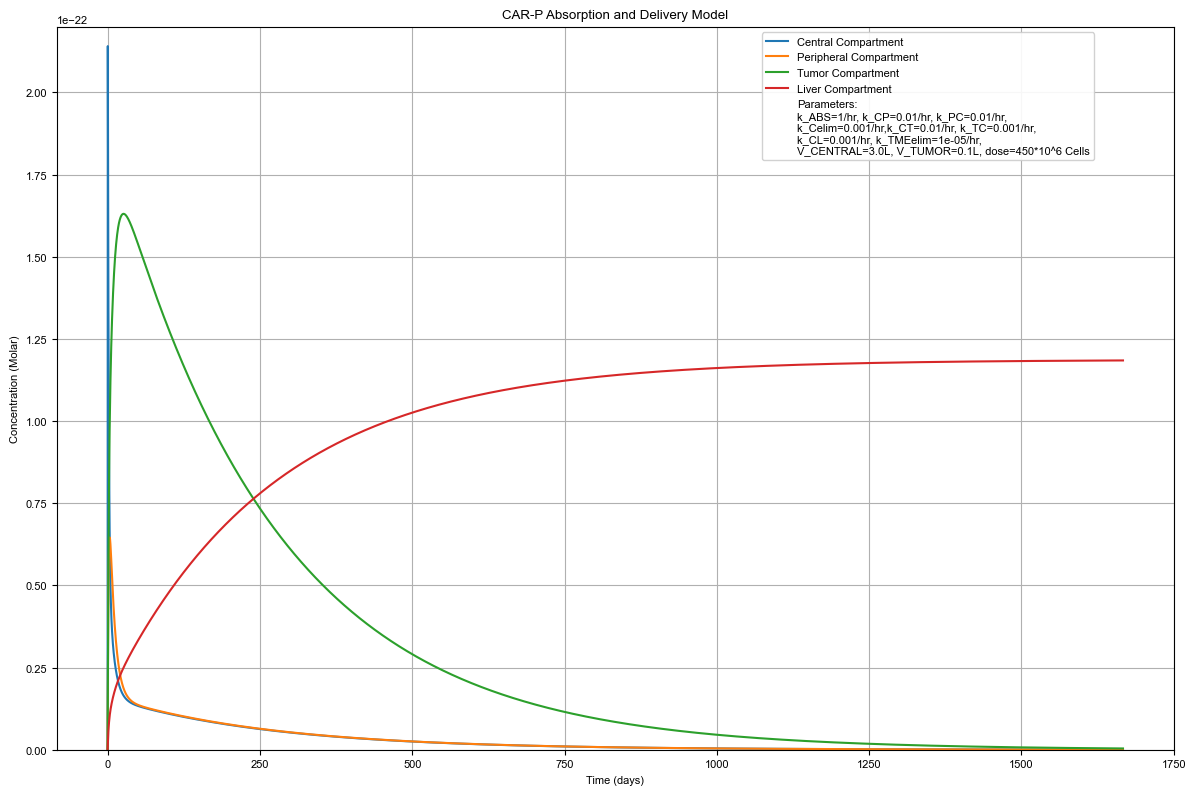

In [7]:
# Time points for simulation
t = np.linspace(0, 40000, 5000)  # Simulate over 48 hours with fine resolution
t_days = t / 24

# Initial conditions: [Dosing Compartment [mol], Central Compartment [mol], Peripheral Compartment [mol], Tumor Compartment [mol], Liver Compartment [mol]]
y0_updated = [dose_moles, 0, 0, 0, 0]

# Solver options for increased precision
solver_options = {'atol': 1e-30, 'rtol': 1e-12} # Adjust tolerances as needed

# Solve ODE for the updated model
solution_updated = odeint(pk_model, y0_updated, t,
                          args=(k_ABS, k_CP, k_PC, k_Celim, k_CT, k_TC,
                                k_CL, k_TMEelim), **solver_options)

# Plot results for all compartments
# plt.figure(figsize=(12, 8))
# plt.plot(t, solution_updated[:, 1], label='Central Compartment')
# plt.plot(t, solution_updated[:, 2], label='Peripheral Compartment')
# plt.plot(t, solution_updated[:, 3], label='Tumor Compartment')
# plt.plot(t, solution_updated[:, 4], label='Liver Compartment')
# plt.xlabel('Time (hours)')
# plt.ylabel('Concentration')
# plt.title('Updated PK Model with Biodistribution and TME Effects')
# plt.legend()
# plt.grid(True)
# plt.show()

# Plot results in DAYS
plt.figure(figsize=(12, 8))
plt.plot(t_days, solution_updated[:, 1], label='Central Compartment')
plt.plot(t_days, solution_updated[:, 2], label='Peripheral Compartment')
plt.plot(t_days, solution_updated[:, 3], label='Tumor Compartment')
plt.plot(t_days, solution_updated[:, 4], label='Liver Compartment')
# plt.xlabel('Time (days)')  # Updated label
# plt.ylabel('Concentration (Molar)')
# plt.title('CAR-P Absorption and Delivery Model')
# plt.legend()
# plt.grid(True)
# plt.show()

# Add parameters to the legend
parameters_text = (
    f"k_ABS={k_ABS}/hr, k_CP={k_CP}/hr, k_PC={k_PC}/hr,\n" 
    f"k_Celim={k_Celim}/hr,k_CT={k_CT}/hr, k_TC={k_TC}/hr,\n"
    f"k_CL={k_CL}/hr, k_TMEelim={k_TMEelim}/hr,\n"
    f"V_CENTRAL={V_CENTRAL}L, V_TUMOR={V_TUMOR}L, dose={dose}*10^6 Cells"
)
plt.plot([], [], ' ', label=f"Parameters:\n{parameters_text}")
plt.ylim(0, 2.2e-22)
# Add labels and title
plt.xlabel('Time (days)')
plt.ylabel('Concentration (Molar)')
plt.title('CAR-P Absorption and Delivery Model')

# Add legend on top of the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.78, 1), frameon=True, framealpha=0.9, ncol=1)  # Adjust position and transparency
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
max_tumor_index = np.argmax(solution_updated[:,3])
time_of_max_tumor = t[max_tumor_index] # in hours
max_tumor_concentration = solution_updated[max_tumor_index, 3]

print(f"Time of Maximum Tumor Concentration: {time_of_max_tumor:.2f} hours")
print(f"Time of Maximum Tumor Concentration: {time_of_max_tumor/24:.2f} days")

print(f"Maximum Tumor Concentration: {max_tumor_concentration:.2e} Molar")

Time of Maximum Tumor Concentration: 632.13 hours
Time of Maximum Tumor Concentration: 26.34 days
Maximum Tumor Concentration: 1.63e-22 Molar


In [39]:
max_tumor_index = np.argmax(solution_updated[:,3])
time_of_max_tumor = t[max_tumor_index] # in hours
max_tumor_concentration = solution_updated[max_tumor_index, 3]

print(f"Time of Maximum Tumor Concentration: {time_of_max_tumor:.2f} hours")
print(f"Time of Maximum Tumor Concentration: {time_of_max_tumor/24:.2f} days")

print(f"Maximum Tumor Concentration: {max_tumor_concentration:.2e} Molar")

Time of Maximum Tumor Concentration: 632.13 hours
Time of Maximum Tumor Concentration: 26.34 days
Maximum Tumor Concentration: 1.63e-22 Molar


## Parameter sweep

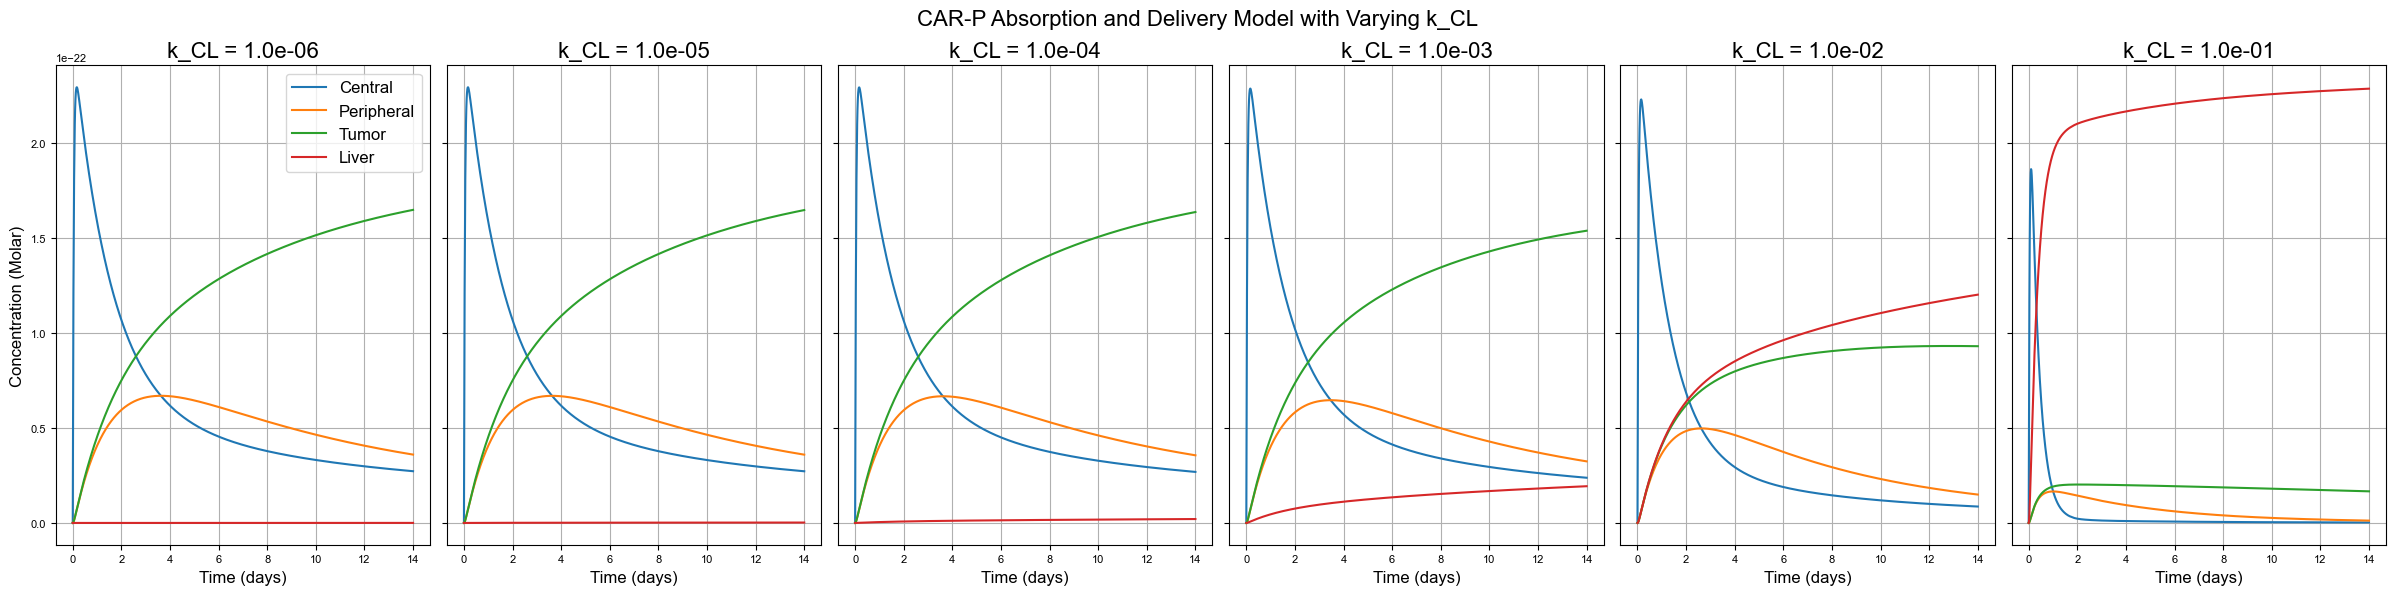

In [ ]:
# EVERYTIME YOU SWITCH, CHANGE IN 5 SPOTS
"""
    'dose': [20, 70, 140, 200, 300, 450], # [10^6 of cells, determined for a 70 kg individual]
"""
# Time points for simulation
t = np.linspace(0, 336, 1000)  # Simulate over 48 hours with fine resolution
t_days = t / 24

# Solver options for increased precision
solver_options = {'atol': 1e-25, 'rtol': 1e-9} # Adjust tolerances as needed

variable = 'k_CL' #### CHANGE THIS
num_sweeps = len(parameter_sweep['k_CL']) #### CHANGE THIS
fig, axes = plt.subplots(1, num_sweeps, figsize=(num_sweeps * 4, 6), sharey=True)

for i, rate_constant in enumerate(parameter_sweep['k_CL']): #### CHANGE THIS
    y0_updated = [dose/AVOGADRO, 0, 0, 0, 0]

    solution_updated = odeint(pk_model, y0_updated, t,
                          args=(k_ABS, k_CP, k_PC, k_Celim, k_CT, k_TC,
                                rate_constant, k_TMEelim), **solver_options) #### CHANGE THIS

    ax = axes[i] if num_sweeps > 1 else axes
    ax.plot(t_days, solution_updated[:, 1], label='Central')
    ax.plot(t_days, solution_updated[:, 2], label='Peripheral')
    ax.plot(t_days, solution_updated[:, 3], label='Tumor')
    ax.plot(t_days, solution_updated[:, 4], label='Liver')

    ax.set_xlabel('Time (days)', fontsize=12)
    # ax.set_title(f'k_CL = {rate_constant:.1e}')
    ax.set_title(f'k_CL = {rate_constant:.1e}', fontsize=16) #### CHANGE THIS
    ax.grid(True)

axes[0].set_ylabel('Concentration (Molar)', fontsize=12)
axes[0].legend(fontsize=12)

plt.suptitle(f'CAR-P Absorption and Delivery Model with Varying {variable}', fontsize=16)

plt.tight_layout()
plt.show()

## Efficacy analysis

AUC in Tumor Compartment: 6.16e-21
Efficacy Threshold Met: Yes


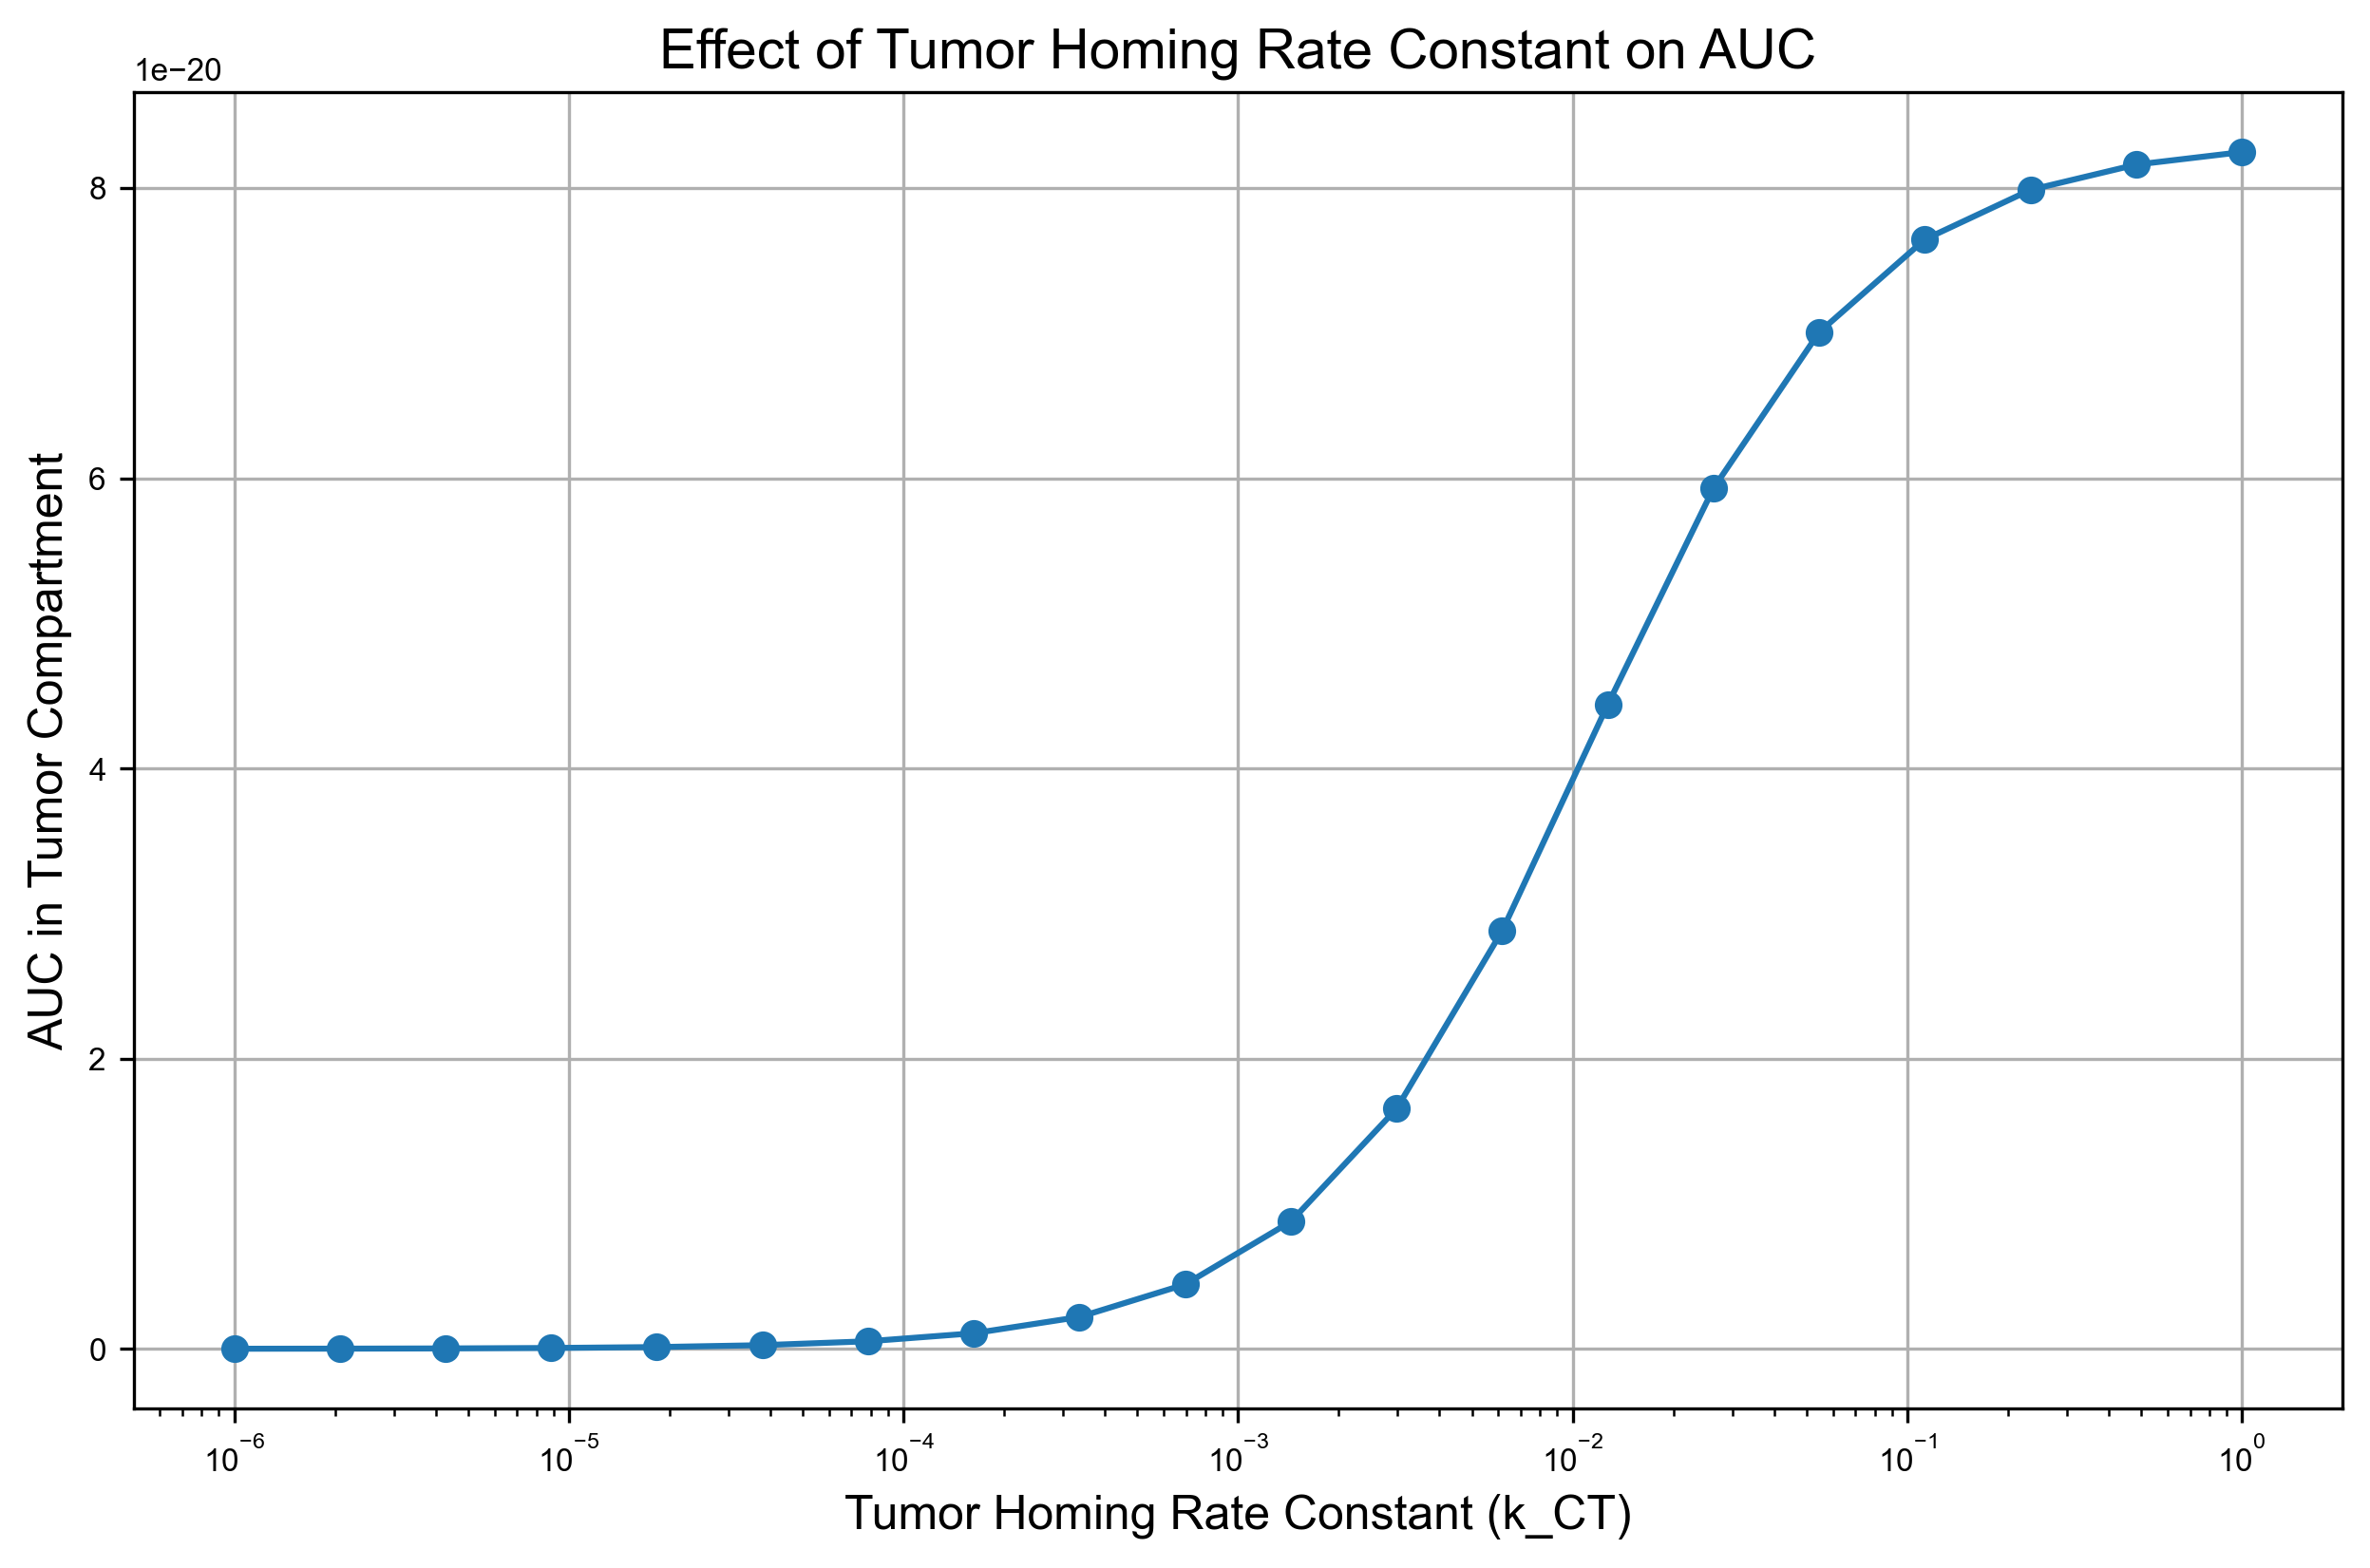

In [28]:
# Quantify Tumor Penetration and Efficacy

# Define efficacy threshold for tumor compartment concentration
efficacy_threshold = 10^-20

# Calculate Area Under the Curve (AUC) for tumor compartment
def calculate_auc(concentration, time):
    return np.trapz(concentration, time)

auc_tumor = calculate_auc(solution_updated[:, 3], t)

# Check if efficacy threshold is met
efficacy_met = np.max(solution_updated[:, 3]) >= efficacy_threshold

print(f"AUC in Tumor Compartment: {auc_tumor:.2e}")
print(f"Efficacy Threshold Met: {'Yes' if efficacy_met else 'No'}")

# Sensitivity Analysis

# Define a function to run the model and calculate AUC for tumor compartment
def run_model_and_calculate_auc(k_tumor_val):
    solution_updated = odeint(pk_model, y0_updated, t,
                          args=(k_ABS, k_CP, k_PC, k_Celim, k_tumor_val, k_TC,
                                k_CL, k_TMEelim), **solver_options)
    auc_sa = calculate_auc(solution_updated[:, 3], t)
    return auc_sa

# Perform sensitivity analysis on tumor homing parameter (k_tumor)
k_tumor_values = np.logspace(-6, 0, 20)   # Test values for sensitivity analysis
auc_results = [run_model_and_calculate_auc(k) for k in k_tumor_values]

# Plot sensitivity analysis results
plt.figure(figsize=(10, 6), dpi=300)
plt.semilogx(k_tumor_values, auc_results, marker='o', linestyle='-')
plt.xlabel('Tumor Homing Rate Constant (k_CT)', fontsize=12)
plt.ylabel('AUC in Tumor Compartment', fontsize=12)
plt.title('Effect of Tumor Homing Rate Constant on AUC', fontsize=14)
plt.grid(True, which="major", ls="-")
plt.show()

In [11]:
# Import the interpolation function
from scipy.interpolate import interp1d

# Define the x-value you want to find the corresponding y-value for
x_target = 10**-3  # Example: x = 0.1

# Interpolate the solution for the desired compartment (e.g., Tumor Compartment)
# Assuming `t` is your x-axis (time) and `solution_updated[:, 3]` is the y-axis (Tumor Compartment)
interpolator = interp1d(t, solution_updated[:, 3], kind='linear', fill_value="extrapolate")

# Get the y-value at the target x-value
y_value_at_x_target = interpolator(x_target)

print(f"Y-value at x = {x_target}: {y_value_at_x_target:.2e}")

Y-value at x = 0.001: 3.74e-28


# Sensitivity analysis

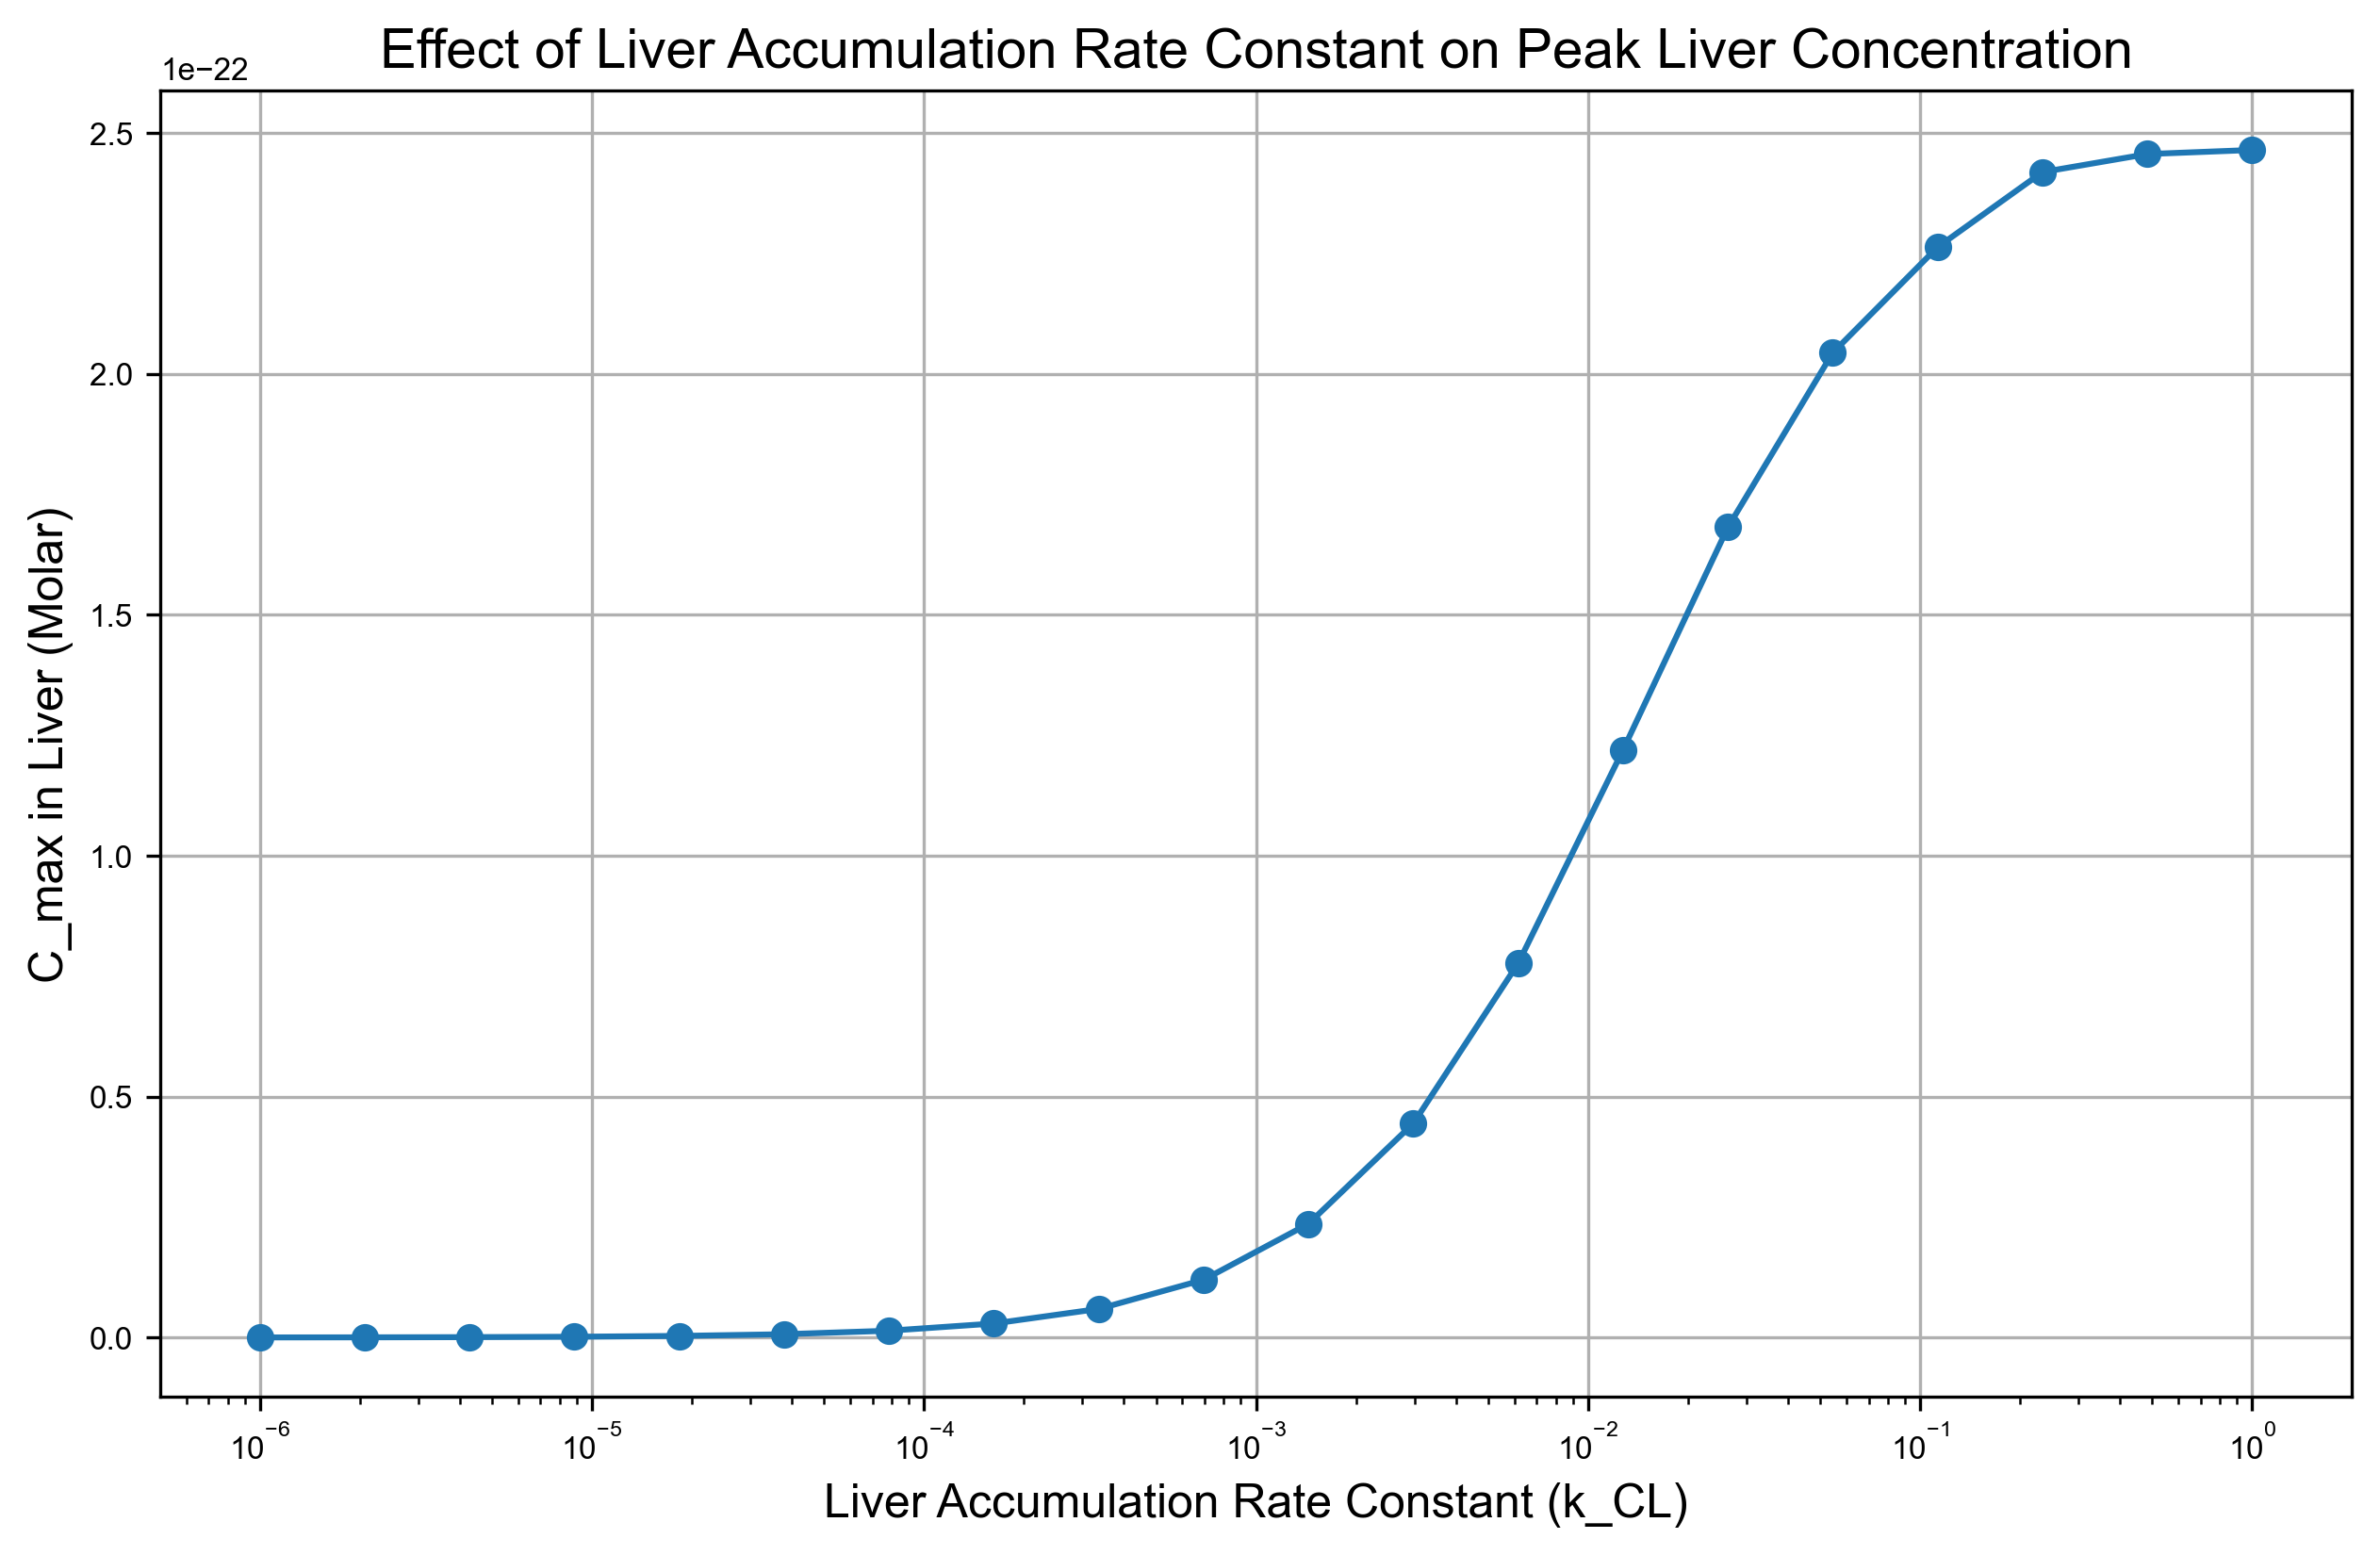

In [30]:
# Define a function to calculate the peak liver concentration for a given k_CL
def calculate_peak_liver_concentration(k_CL):
    solution = odeint(pk_model, y0_updated, t,
                      args=(k_ABS, k_CP, k_PC, k_Celim, k_CT, k_TC,
                            k_CL, k_TMEelim))
    peak_liver_concentration = np.max(solution[:, 4])  # Liver compartment is index 4
    return peak_liver_concentration

# Perform the analysis for varying k_a values
k_CL_values = np.logspace(-6, 0, num=20)  # Use 'k_ABS' for absorption rate constant
peak_liver_concentrations = [calculate_peak_liver_concentration(k) for k in k_CL_values]

# Plot the results
plt.figure(figsize=(10, 6), dpi=300)
plt.semilogx(k_CL_values, peak_liver_concentrations, marker='o', linestyle='-')
plt.xlabel('Liver Accumulation Rate Constant (k_CL)', fontsize=12)
plt.ylabel('C_max in Liver (Molar)', fontsize=12)
plt.title('Effect of Liver Accumulation Rate Constant on Peak Liver Concentration', fontsize=14)
plt.grid(True)
plt.show()

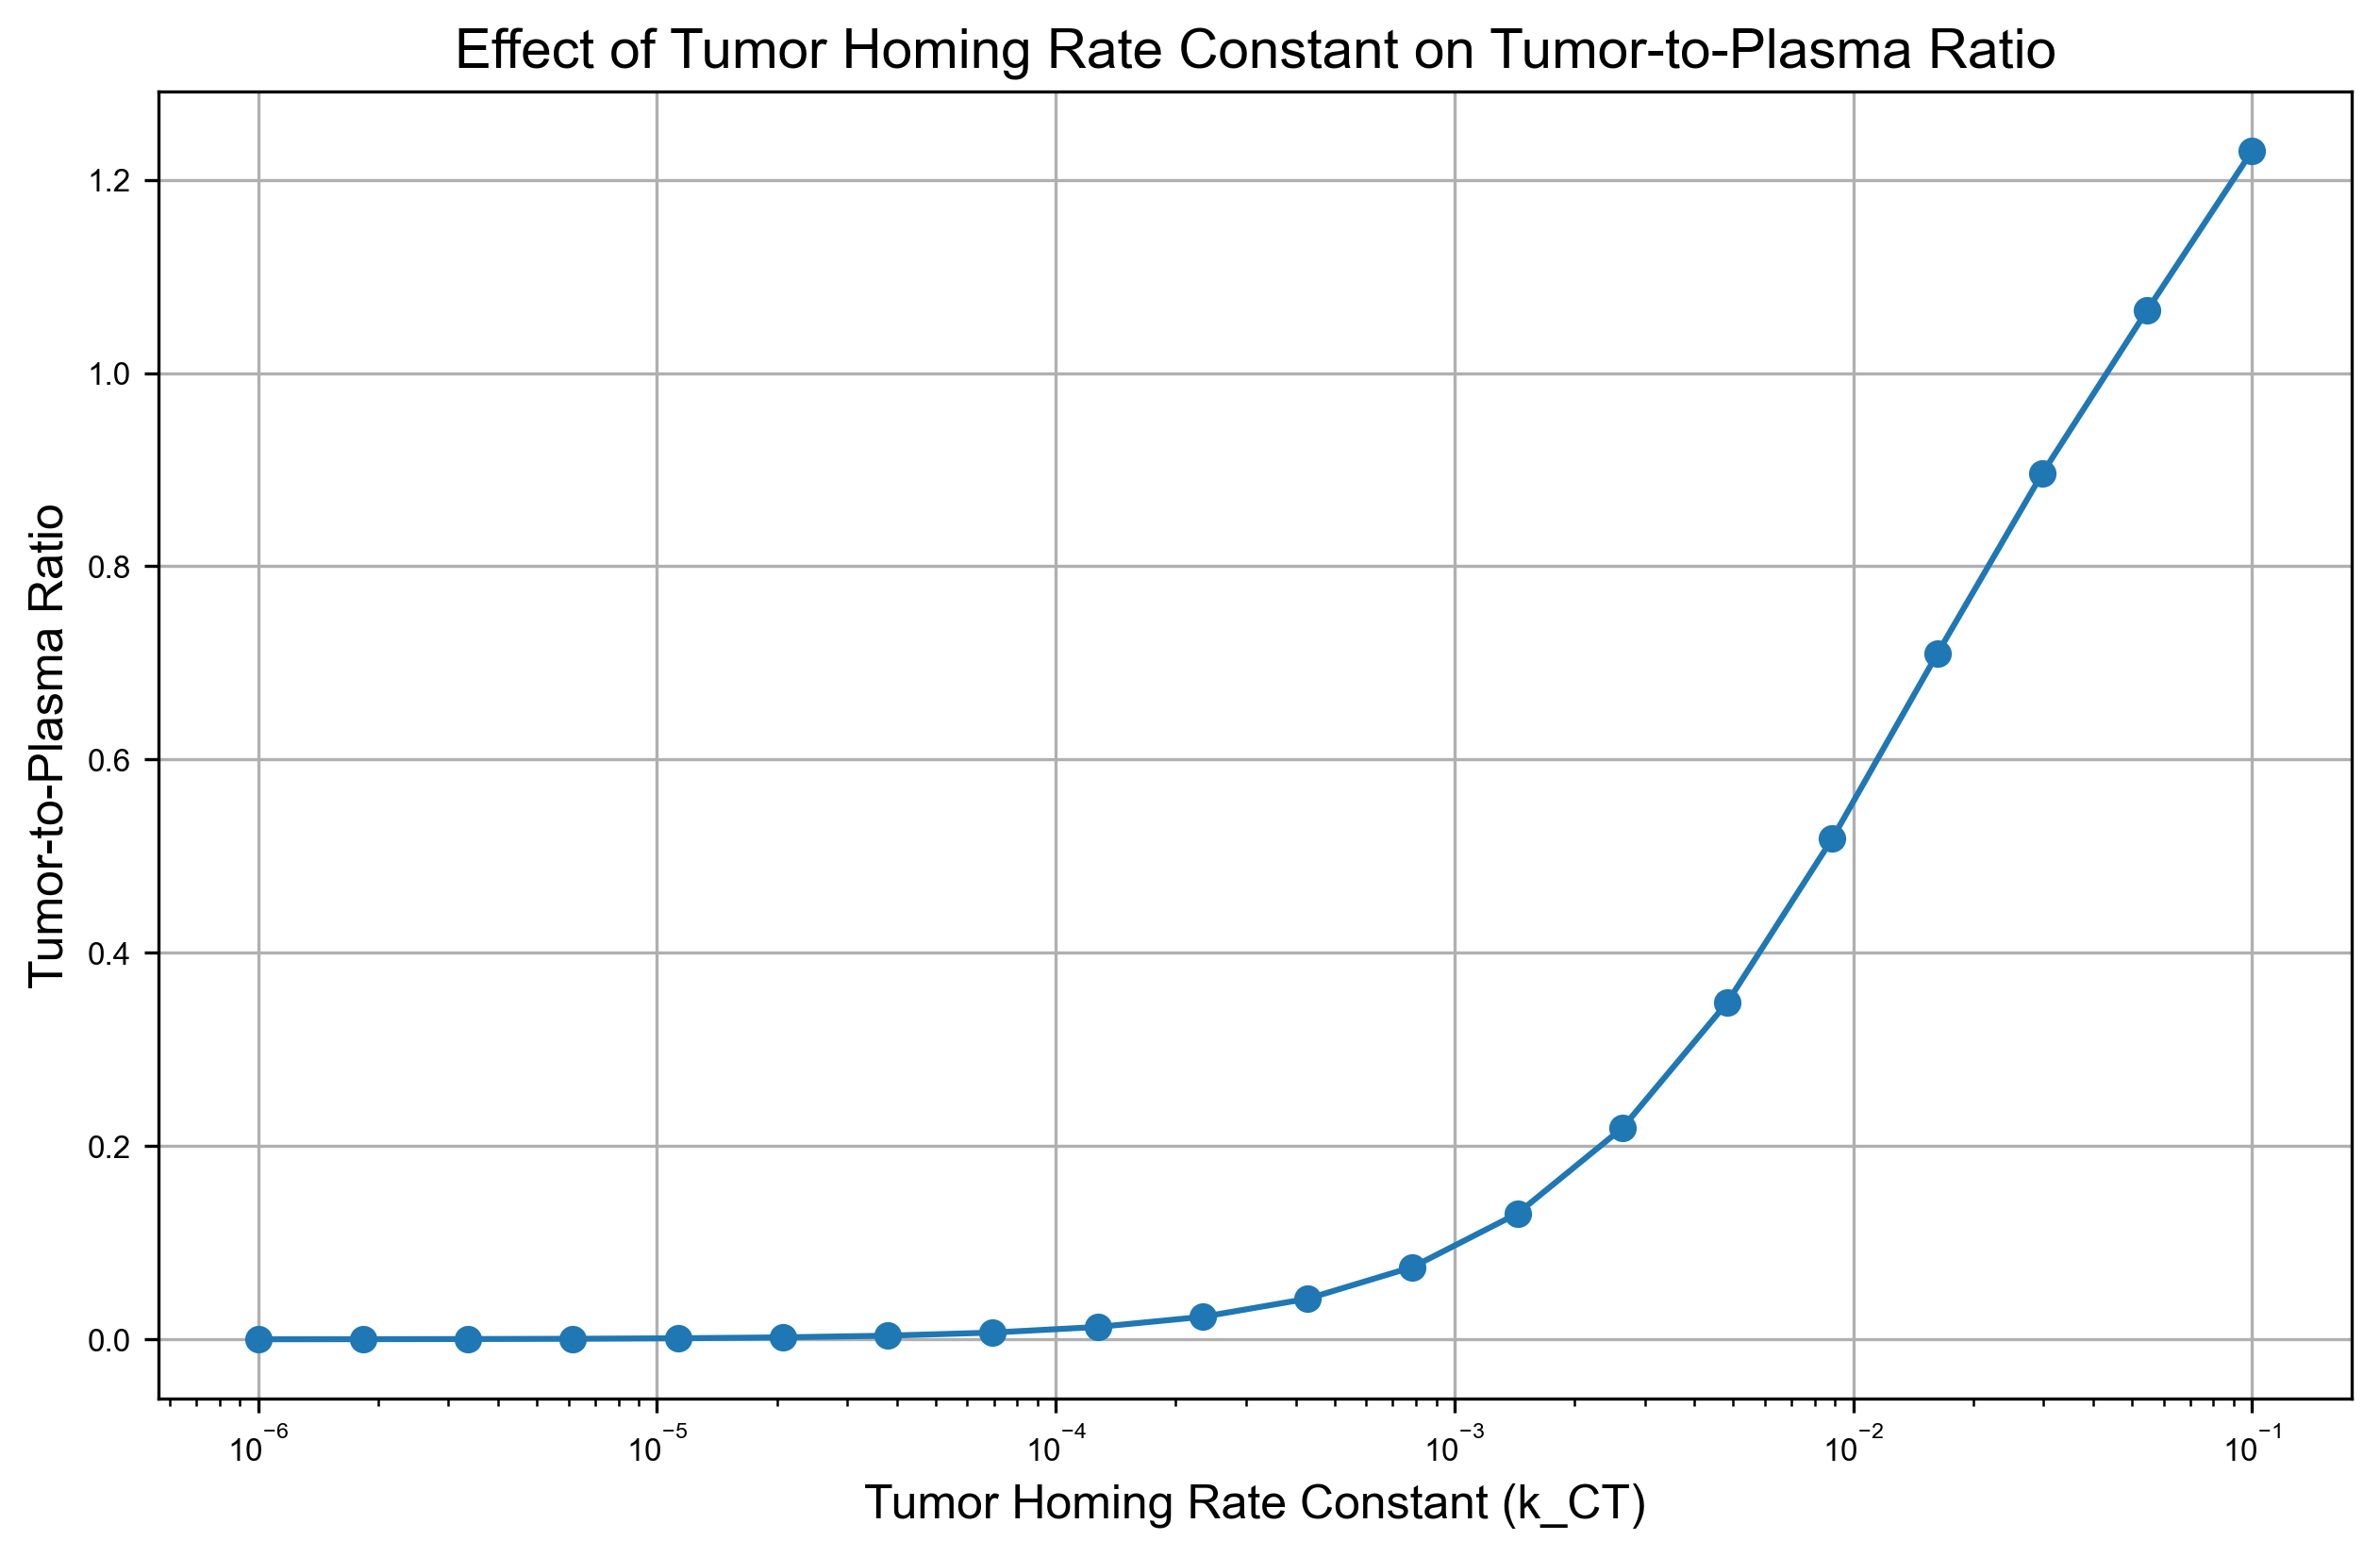

In [32]:
# Define a function to calculate the tumor-to-plasma ratio for a given k_CT
def calculate_tumor_plasma_ratio(k_CT_value):
    solution = odeint(pk_model, y0_updated, t,
                      args=(k_ABS, k_CP, k_PC, k_Celim, k_CT_value, k_TC,
                            k_CL, k_TMEelim))
    # Initial conditions: [Dosing Compartment, Central Compartment, Peripheral Compartment,
    # Tumor Compartment, Liver Compartment]
    peak_tumor_concentration = np.max(solution[:, 3])  # Tumor compartment is index 3
    peak_plasma_concentration = np.max(solution[:, 1])  # Central compartment is index 1
    return peak_tumor_concentration / peak_plasma_concentration

# Perform the analysis for varying k_CT values
k_CT_values = np.logspace(-6, -1, num=20)  # Use 'k_ABS' for absorption rate constant
tumor_plasma_ratios = [calculate_tumor_plasma_ratio(k) for k in k_CT_values]

# Plot the results
plt.figure(figsize=(10, 6), dpi=300)
plt.semilogx(k_CT_values, tumor_plasma_ratios, marker='o', linestyle='-')
plt.xlabel('Tumor Homing Rate Constant (k_CT)', fontsize=12)
plt.ylabel('Tumor-to-Plasma Ratio', fontsize=12)
plt.title('Effect of Tumor Homing Rate Constant on Tumor-to-Plasma Ratio', fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
# Define a function to calculate the therapeutic index
def calculate_therapeutic_index(mtc, mec):
    """
    Calculate the therapeutic index (TI) as the ratio of MTC to MEC.

    Parameters:
    - mtc: Minimum Toxic Concentration (Molar)
    - mec: Minimum Effective Concentration (Molar)

    Returns:
    - Therapeutic Index (TI)
    """
    if mec == 0:
        raise ValueError("MEC cannot be zero.")
    return mtc / mec

# Example values for MTC and MEC (in Molar)
mtc = 1e-5  # Example: 10 µM COMES FROM JEANNIE'S ANALYSIS
mec = 1.63e-20  # Example: 0.1 µM COMES FROM KATIE'S ANALYSIS

# Calculate the therapeutic index
therapeutic_index = calculate_therapeutic_index(mtc, mec)
print(f"Therapeutic Index (TI): {therapeutic_index:.2f}")
# A higher TI indicates a safer drug, while a lower TI indivates a narrow safety margin